# Анализ данных о транзакциях

## Данные о транзакциях:

- InvoiceNo — номер заказа  
- StockCode — код товара  
- Description — описание товара  
- Quantity — количество единиц товара, добавленных в заказ  
- InvoiceDate — дата транзакции   
- UnitPrice — цена за единицу товара  
- CustomerID — id клиента  
- Country — страна, где проживает клиент

Каждая строка — это отдельная транзакция (т.е. добавление одного товара в корзину или его удаление, если это запись об отмененной транзакции). В данных нет кода для каждой транзакции, только для товара и для заказа. В одном заказе может быть несколько транзакций. Разные товары могут быть в разных заказах. Неотмененные транзакции считаются реализованными (т.е. эти товары были куплены).

## Цели:
1. Анализ данных о транзакциях;
2. Получение инсайтов для бизнес-решений.

## Задачи:
1. Проанализировать покупки наиболее активных пользователей одной из Германии;
2. Определим, какой товар отобранные активные пользователи из Германии добавляли в корзину чаще всего;
3. Найти наиболее крупных по выручке заказов;
4. Определить количество транзакций того или иного статуса;
5. Посчитать количество успешных транзакций каждого пользователя.

# Часть 1

#### Прочитаем данные с кодировкой `ISO-8859-1`, запишем полученный датафрейм в `retail`. Проверим, встречаются ли в данных повторяющиеся наблюдения и удалим дупликаты.

In [35]:
import pandas  as pd
import seaborn as sns
retail = pd.read_csv('5_data.zip', encoding='ISO-8859-1')
retail



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


#### Отберём и удалим дупликаты.

In [26]:
duplicates = retail.loc[retail.duplicated()]
retail = retail.drop_duplicates()



#### Продолжим предобработку данных перед их анализом. 
Данные содержат в себе записи как об успешных транзакциях, так и об отмененных. Если пользователь отменил транзакцию, в начале номера заказа (см.колонку `InvoiceNo`) ставится `C` (от `canceled`).  *Удалим эти записи из датафрейма `retail`, дальше они нам не понадобятся .*

#### Определим для каждой строки в колонке `InvoiceNo`, начинается ли эта строка с английской буквы `C`, и посчитаем количество таких строк.

In [27]:
retail.InvoiceNo.str.startswith('C').sum()



9251

#### Удалим записи об отмененных транзакциях из датафрейма `retail`.

In [28]:
retail = retail.loc[~retail.InvoiceNo.str.startswith('C')]


## Задача 1
### Проанализировать покупки наиболее активных пользователей одной из Германии. 

#### Для этого сначала найдём пользователей из Германии, которые совершили значительное количество заказов, т.е. выше определенного порога N.

Мои коллеги расчитали, что этот порог — 80-й процентиль. То есть нужно посчитать число заказов (см.колонку `InvoiceNo`) для каждого пользователя (см. колонку `CustomerID`) из Германии (Germany) и оставить только тех, кто совершил более N заказов, где N – 80-й процентиль. 

In [8]:
retail = retail.query("Country == 'Germany'")


#### Посчитаем количество заказов (не транзакций) для каждого пользователя и сохраним результат в новый датафрейм `invoice_dist`

In [9]:
invoice_dist = retail.groupby('CustomerID', as_index=False)\
                     .agg({'InvoiceNo': 'nunique'})\
                     .rename(columns={'InvoiceNo': 'total_invoices'})


In [10]:
N = invoice_dist.total_invoices.quantile(q=0.8)



#### Определим значение порога N – 80го процентиля для числа заказов

In [11]:
invoice_dist = invoice_dist.loc[invoice_dist.total_invoices > N]



#### Оставим только записи о тех клиентах, кто совершил заказов больше, чем порог N

In [12]:
germany_top = invoice_dist['CustomerID']



####  Запишем в переменную `germany_top` только оставшиеся id пользователей

In [13]:
retail = retail.query("Country == 'Germany'")
invoice_dist = retail.groupby('CustomerID', as_index=False)\
                     .agg({'InvoiceNo': 'nunique'})\
                     .rename(columns={'InvoiceNo': 'total_invoices'})
N = invoice_dist.total_invoices.quantile(q=0.8)
invoice_dist = invoice_dist.loc[invoice_dist.total_invoices > N]
germany_top = invoice_dist['CustomerID']
germany_top

3     12471.0
6     12474.0
8     12476.0
12    12481.0
16    12500.0
26    12524.0
37    12569.0
44    12600.0
51    12619.0
52    12621.0
56    12626.0
64    12647.0
69    12662.0
77    12705.0
78    12708.0
79    12709.0
81    12712.0
83    12720.0
Name: CustomerID, dtype: float64

#### Отберём все записи о транзакциях интересующих пользователей. 

In [14]:
retail.loc[retail['CustomerID'].isin(germany_top)]



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,12/1/2010 13:04,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,12/1/2010 13:04,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,12/1/2010 13:04,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662.0,Germany
...,...,...,...,...,...,...,...,...
541726,581570,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,12/9/2011 11:59,4.95,12662.0,Germany
541727,581570,23077,DOUGHNUT LIP GLOSS,20,12/9/2011 11:59,1.25,12662.0,Germany
541728,581570,20750,RED RETROSPOT MINI CASES,2,12/9/2011 11:59,7.95,12662.0,Germany
541729,581570,22505,MEMO BOARD COTTAGE DESIGN,4,12/9/2011 11:59,4.95,12662.0,Germany


In [15]:
top_retail_germany = retail.loc[retail['CustomerID'].isin(germany_top)]


## Задача 2
### Определим, какой товар отобранные активные пользователи из Германии (см.датафрейм `top_retail_germany`) добавляли в корзину чаще всего (без учета количества товара).

#### Посчитаем, сколько раз каждый из товаров добавляли в корзину и самый популярный товар.
(товар с id 22326 добавляли в корзину чаще всего)

In [16]:
top_retail_germany.StockCode.value_counts()



POST     213
22326     52
22328     38
22423     34
20719     30
        ... 
23179      1
23019      1
23299      1
21576      1
22242      1
Name: StockCode, Length: 1158, dtype: int64

## Задача 3

### Найдём 5 наиболее крупных по выручке заказов.

Для этого сначала посчитаем сумму покупки для каждой транзакции, т.е. создадим колонку `Revenue` с суммой покупки, используя колонки `Quantity` и `UnitPrice`. Потом для каждого заказа (см.колонку `InvoiceNo`) суммируйем выручку всех входящих в него транзакций — это будет колонка `TotalRevenue`.

In [29]:
retail = retail.assign(Revenue = retail.UnitPrice * retail.Quantity)
retail = retail.groupby('InvoiceNo').agg({'Revenue':'sum'})  
retail



,Revenue
InvoiceNo,
536365,139.12
536366,22.20
536367,278.73
536368,70.05
536369,17.85
...,...
581586,339.20
581587,249.45
A563185,11062.06


In [18]:
retail = retail.rename(columns={'Revenue': 'TotalRevenue'})
retail


,TotalRevenue
InvoiceNo,
536527,261.48
536840,155.35
536861,303.50
536967,76.50
536983,175.53
...,...
581266,1188.20
581494,339.14
581570,224.95


In [19]:
retail = retail.rename(columns={'Revenue': 'TotalRevenue'})



In [20]:
retail = retail.sort_values('TotalRevenue', ascending=False).head(5)
retail



,TotalRevenue
InvoiceNo,
552978,9341.26
564856,4257.06
543737,2355.95
581179,2238.51
550137,2221.02


In [21]:
retail.index




Index(['552978', '564856', '543737', '581179', '550137'], dtype='object', name='InvoiceNo')

# Часть 2
Задача — проанализировать транзакции пользователей с точки зрения статуса транзакций. 

Работать с прошлыми данными мы закончили. 
Переключаемся на работу с новым датасетом `transaction_data.csv`. 

## Данные:

- date – дата (2020-03-02 00:00:00 – 2020-03-02 01:29:05)  
- name – имя пользователя  
- transaction – статус транзакции  
- minute – сколько минут прошло с начала дня (эта колонка будет доступна в данных с определенного шага)

Каждая строка — это отдельная транзакция.

#### Определим, сколько в датасете пропущенных значений

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
      
Данные находятся в файле формата CSV. Для их загрузки воспользуйтесь функцией `pd.read_csv()`, передав в качестве аргумента путь к файлу. Например,
```python
df = pd.read_csv('data.csv')
```
считает файл `data.csv`, хранящийся в той же папке, что и юпитер ноутбук, в котором вы сейчас работаете.
</p>
</details>

In [30]:
import pandas as pd
data = pd.read_csv('transaction_data.csv')
data




,date,name,transaction
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled
...,...,...,...
5310,2020-03-02 00:09:28,Vasilisa_Fedorova,successfull
5311,2020-03-02 00:46:31,Vasilisa_Ozerova,successfull
5312,2020-03-02 00:16:38,Olga_Polyanova,successfull
5313,2020-03-02 00:13:00,Ekaterina_Smirnova,successfull


In [31]:
data.dtypes




date           object
name           object
transaction    object
dtype: object

In [32]:
data.describe()




,date,name,transaction
count,5315,5315,5315
unique,3373,56,3
top,2020-03-02 00:35:03,Masha_Ozerova,successfull
freq,6,112,3692


In [33]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         5315 non-null   object
 1   name         5315 non-null   object
 2   transaction  5315 non-null   object
dtypes: object(3)
memory usage: 124.7+ KB


## Задача 4

### Определим количество транзакций того или иного статуса и представим эту информацию с помощью графика барплот.

#### Посчитаем количество записей для каждого статуса транзакций.

In [36]:
data_counts = data.transaction.value_counts()


#### На барплоте по оси `x` будет расположено название статуса, а по оси `y` – количество транзакций с таким статусом.

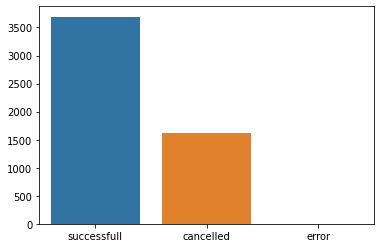

In [37]:
sns.barplot(x = data_counts.index, y=data_counts.values )



## Задача 5
### Посчитаем количество успешных транзакций каждого пользователя.

#### Оставим записи только об успешных транзакциях (см.колонку `transaction`)

In [39]:
data.loc[data["transaction"] == 'successfull']



,date,name,transaction
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
6,2020-03-02 00:54:12,Olga_Lesnova,successfull
7,2020-03-02 00:18:43,Irina_Lesnova,successfull
8,2020-03-02 00:06:10,Vasilisa_Petrova,successfull
...,...,...,...
5309,2020-03-02 01:26:13,Olga_Ozerova,successfull
5310,2020-03-02 00:09:28,Vasilisa_Fedorova,successfull
5311,2020-03-02 00:46:31,Vasilisa_Ozerova,successfull
5312,2020-03-02 00:16:38,Olga_Polyanova,successfull


#### Посчитаем, сколько успешных транзакций совершил каждый пользователь.

In [40]:
data_success = data.loc[data["transaction"] == 'successfull']\
        .groupby('name', as_index=False)\
        .size()\
        .describe()
data_success



,size
count,56.000000
mean,65.928571
std,7.787769
min,46.000000
25%,61.000000
50%,64.000000
75%,72.000000
max,82.000000


#### На основе расчетов с прошлого шага построим гистограмму, на которой по оси `x` будет отложено число транзакций, а по оси `y` — количество пользователей с таким числом транзакций.**

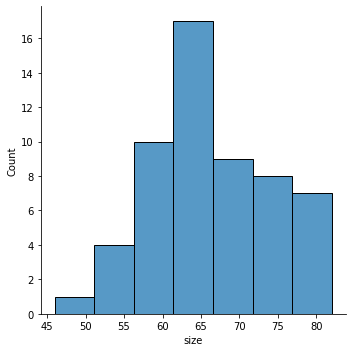

In [43]:
data_success = data.loc[data["transaction"] == 'successfull']\
        .groupby('name', as_index=False)\
        .size()
sns.displot(data=data_success, x='size')


## Итоги

В этом уроке был проведён анализ нескольких наборов данных о транзакциях. Для этого понадобилось подготовить данные к анализу, удалять дубликаты и другие лишние данные, определять, какие данные нужно оставить, а в каких есть ошибка, заполнять пропуски, строить сводные таблицы и корректные графики.

В проекте были выполнены задачи: 

1. Проанализировать покупки наиболее активных пользователей одной из Германии;
2. Товар с id 22326 отобранные активные пользователи из Германии добавляли в корзину чаще всего;
3. Наиболее крупные по выручке заказы: 581483, 541431, 574941, 576365, 556444;
4. Определили количество транзакций того или иного статуса: удачных транзакций около 3500, неудачных - около 1500;
5. Посчитано количество успешных транзакций каждого пользователя. Пользователи в среднем совершили примерно по 66 транзакций. Максимальное число транзакций – 82. Примерно 25% пользователей совершили менее 61 транзакции.